In [36]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, BatchNormalization, Activation, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

In [37]:
reviews = pd.read_csv('data/winereviewscsv.csv', index_col=0)

# Duomenų tvarkymas

In [38]:
print("Length of dataframe before duplicates are removed:", len(reviews))
reviews.head()

Length of dataframe before duplicates are removed: 129971


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Pradžioje turime beveik 130 000 eilučių. Pažiūrėkime, kas gaunasi pašalinus nereikalingus duomenis.

In [39]:
parsed_data = reviews[reviews.duplicated('description', keep=False)] #panaikiname besikartojancius aprasymus
print("Length of dataframe after duplicates are removed:", len(parsed_data)) 

parsed_data.dropna(subset=['description', 'points']) #panaikiname Nans (taskuose ir aprasymuose)
print("Length of dataframe after NaNs are removed:", len(parsed_data)) 

parsed_data.head()

Length of dataframe after duplicates are removed: 20026
Length of dataframe after NaNs are removed: 20026


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam
10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
11,France,"This is a dry wine, very spicy, with a tight, ...",NaN,87,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Leon Beyer 2012 Gewurztraminer (Alsace),Gewürztraminer,Leon Beyer
12,US,"Slightly reduced, this wine offers a chalky, t...",NaN,87,34.0,California,Alexander Valley,Sonoma,Virginie Boone,@vboone,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini
13,Italy,This is dominated by oak and oak-driven aromas...,Rosso,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Masseria Setteporte 2012 Rosso (Etna),Nerello Mascalese,Masseria Setteporte


# Duomenų apžvalga

'Aprašymas' vs 'Taškai'

In [40]:
dp = parsed_data[['description','points']]
dp.info()
dp.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20026 entries, 9 to 129913
Data columns (total 2 columns):
description    20026 non-null object
points         20026 non-null int64
dtypes: int64(1), object(1)
memory usage: 469.4+ KB


,description,points
9,This has great depth of flavor with its fresh ...,87
10,"Soft, supple plum envelopes an oaky structure ...",87
11,"This is a dry wine, very spicy, with a tight, ...",87
12,"Slightly reduced, this wine offers a chalky, t...",87
13,This is dominated by oak and oak-driven aromas...,87


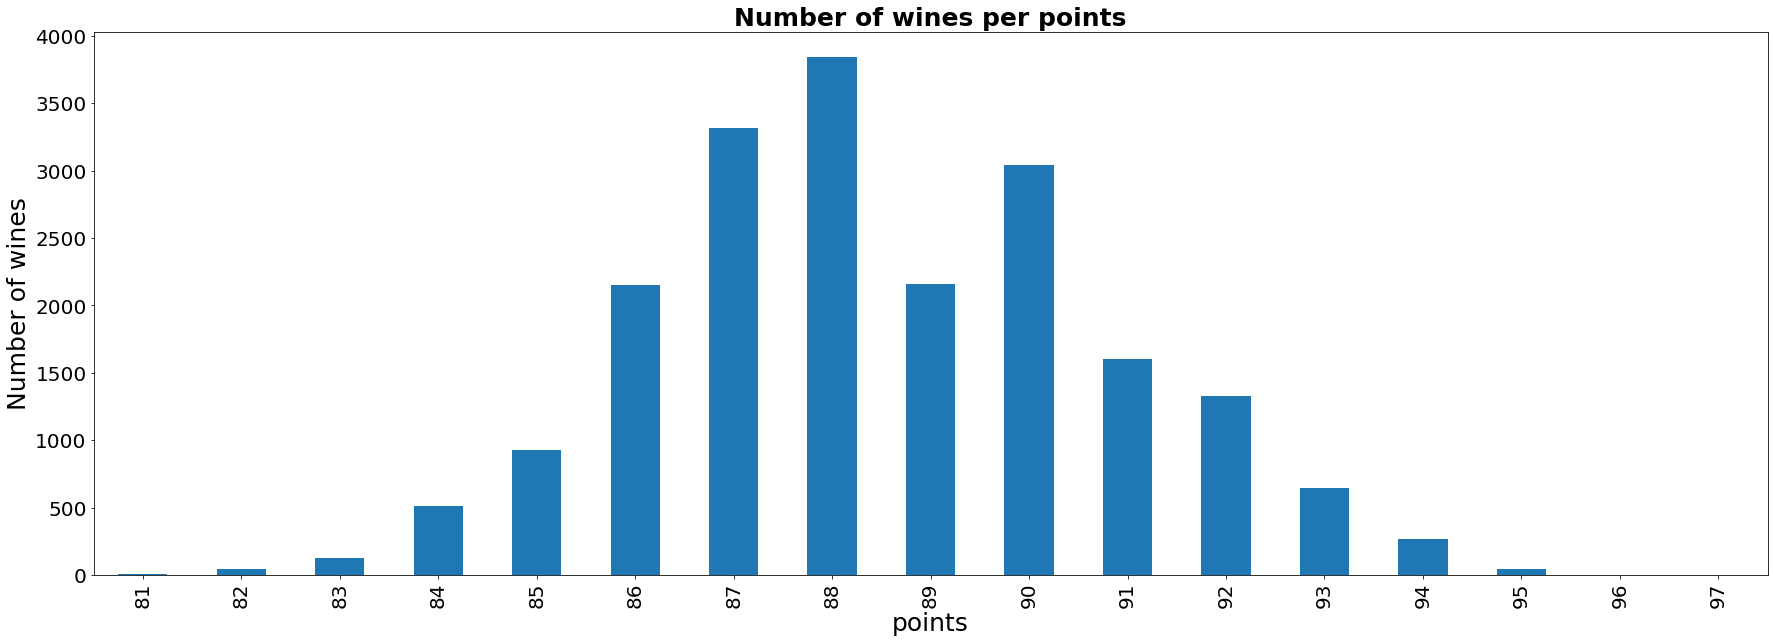

In [41]:
fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Number of wines per points', fontweight="bold", size=25) # pavadinimas
ax.set_ylabel('Number of wines', fontsize = 25) # Y asis
ax.set_xlabel('Points', fontsize = 25) # X asis
dp.groupby(['points']).count()['description'].plot(ax=ax, kind='bar')

'Aprašymo ilgis' vs 'Taškai'

In [42]:
dp = dp.assign(description_length = dp['description'].apply(len))
dp.info()
dp.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20026 entries, 9 to 129913
Data columns (total 3 columns):
description           20026 non-null object
points                20026 non-null int64
description_length    20026 non-null int64
dtypes: int64(2), object(1)
memory usage: 625.8+ KB


,description,points,description_length
9,This has great depth of flavor with its fresh ...,87,160
10,"Soft, supple plum envelopes an oaky structure ...",87,243
11,"This is a dry wine, very spicy, with a tight, ...",87,179
12,"Slightly reduced, this wine offers a chalky, t...",87,171
13,This is dominated by oak and oak-driven aromas...,87,234


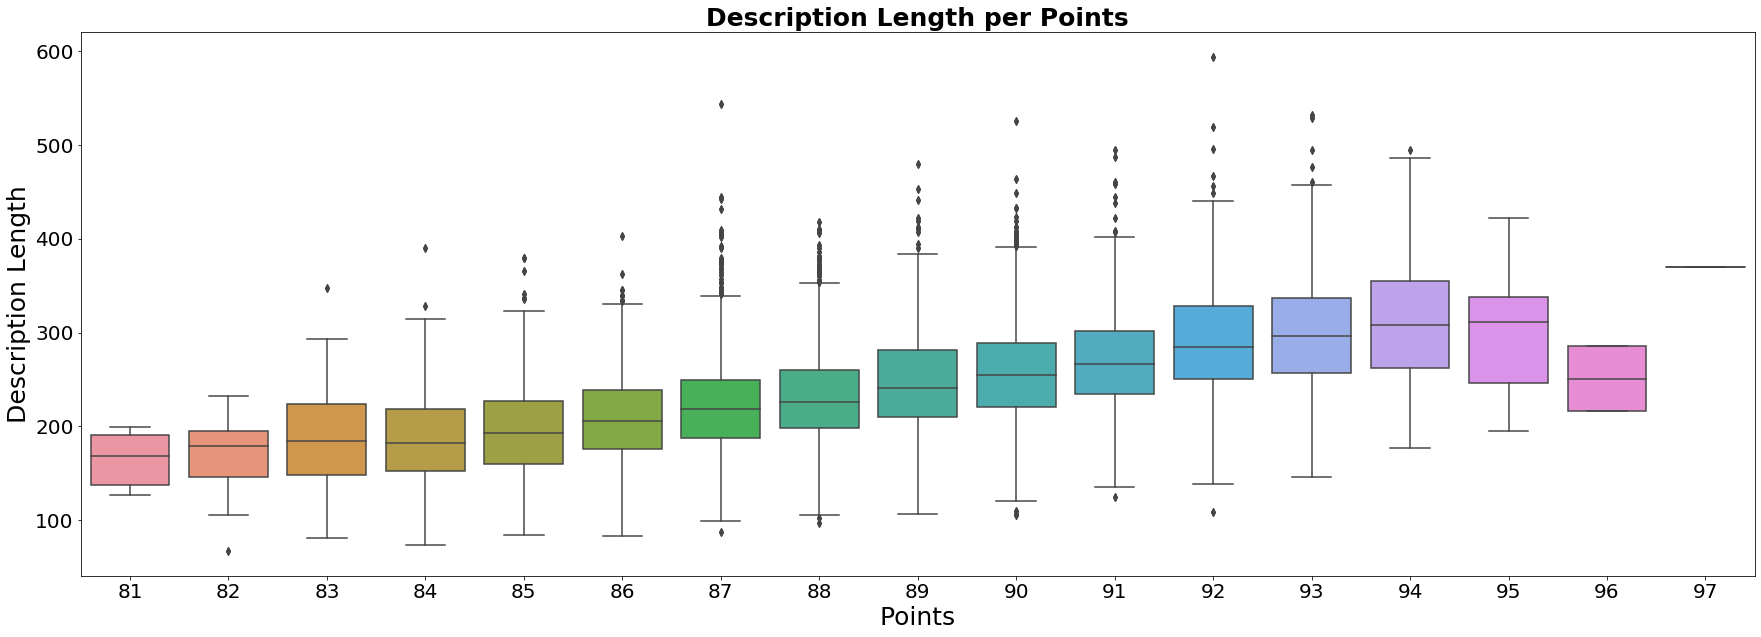

In [43]:
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(x='points', y='description_length', data=dp)
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Description Length per Points', fontweight="bold", size=25) # Title
ax.set_ylabel('Description Length', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
plt.show()

Iš grafiko galime pastebėti, kad kuo geresnis vynas, tuo plačiau jis aprašytas.

# Modelio supaprastinimas

Supaprastinkime modelį štai taip:

1 - nuo 80 iki 84 taškų (Žemiau nei vidutiniai vynai)

2 - nuo 84 iki 88 taškų (Vidutiniai vynai)

3 - nuo 88 iki 92 taškų (Geri vynai)

4 - nuo 92 iki 96 taškų (labai geri vynai)

5 - nuo 96 iki 100 taškų (Puikūs vynai)

In [44]:
def transform_points_simplified(points):
    if points < 84:
        return 1
    elif points >= 84 and points < 88:
        return 2 
    elif points >= 88 and points < 92:
        return 3 
    elif points >= 92 and points < 96:
        return 4 
    else:
        return 

In [45]:
    dp = dp.assign(points_simplified = dp['points'].apply(transform_points_simplified))
dp.head()

,description,points,description_length,points_simplified
9,This has great depth of flavor with its fresh ...,87,160,2.0
10,"Soft, supple plum envelopes an oaky structure ...",87,243,2.0
11,"This is a dry wine, very spicy, with a tight, ...",87,179,2.0
12,"Slightly reduced, this wine offers a chalky, t...",87,171,2.0
13,This is dominated by oak and oak-driven aromas...,87,234,2.0


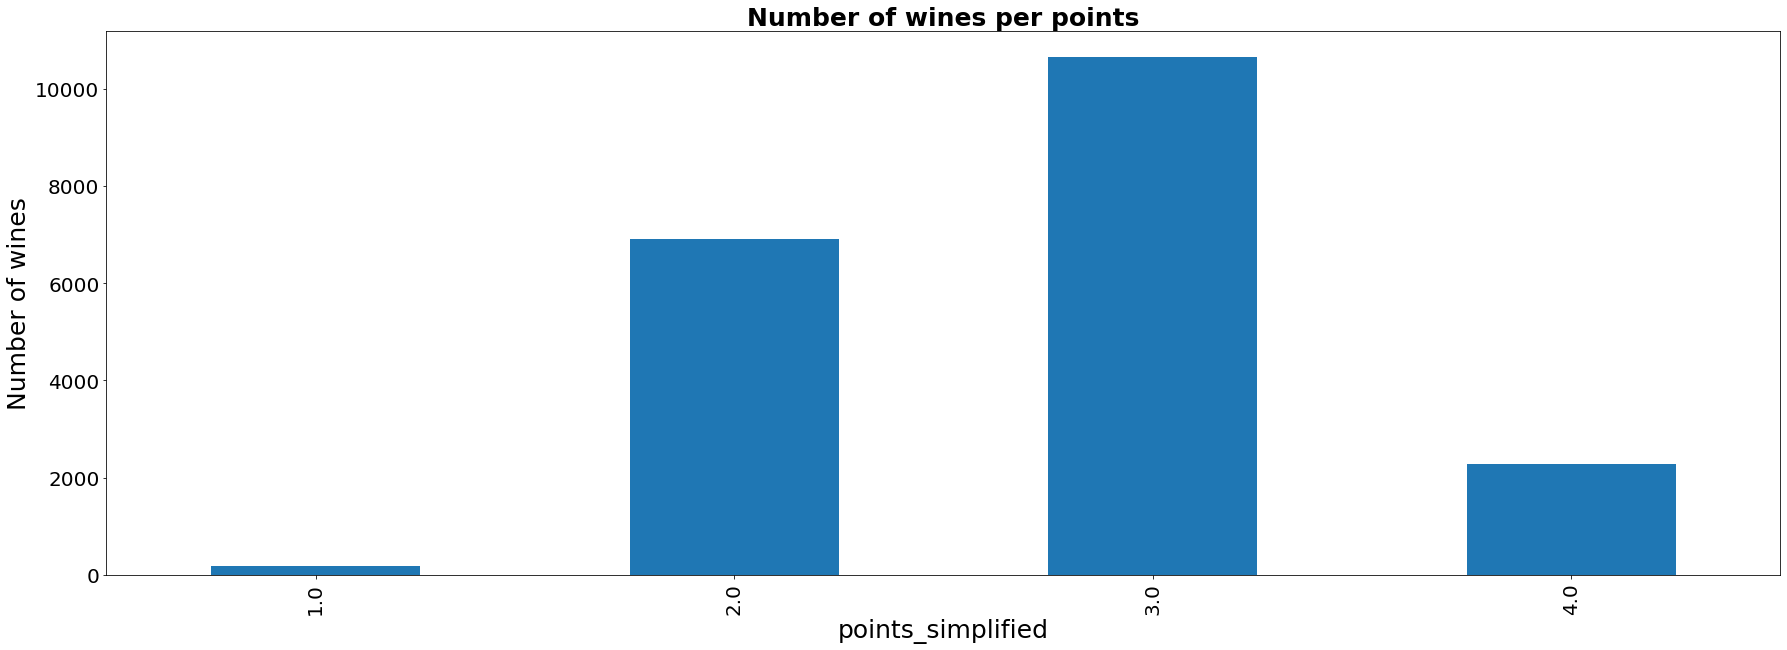

In [46]:
fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Number of wines per points', fontweight="bold", size=25) # Title
ax.set_ylabel('Number of wines', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
dp.groupby(['points_simplified']).count()['description'].plot(ax=ax, kind='bar')

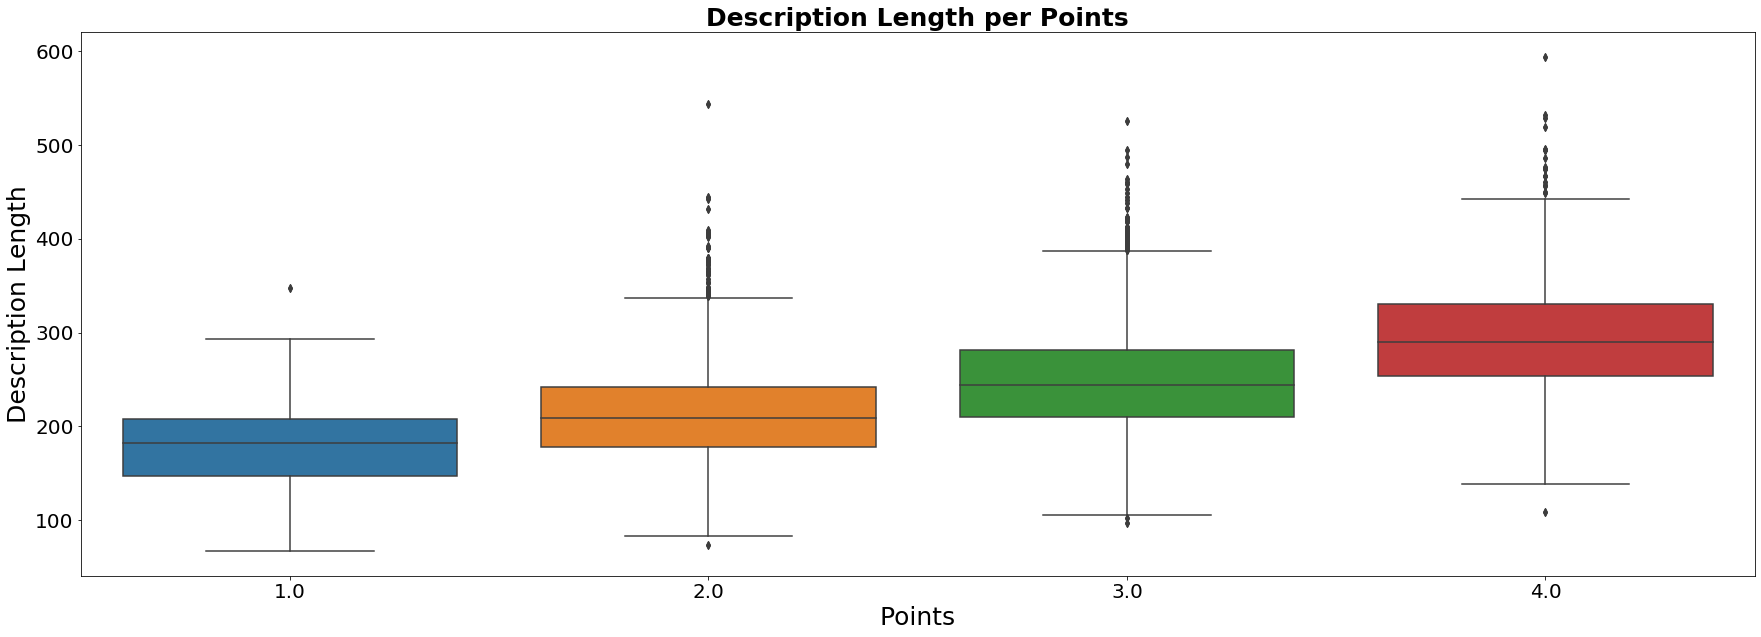

In [47]:
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(x='points_simplified', y='description_length', data=dp)
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Description Length per Points', fontweight="bold", size=25) # Title
ax.set_ylabel('Description Length', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
plt.show()

# Aprašymo vektorizacija

In [48]:
X = dp['description']
y = dp['points_simplified']

vectorizer = CountVectorizer()
vectorizer.fit(X)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [49]:
X = vectorizer.transform(X)
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Nenulinių reikšmių procentai
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (20026, 10992)
Amount of Non-Zero occurrences:  683286
Density: 0.3104070603412071


# Treniruojami ir testuojami duomenys

In [50]:
dp[dp==np.inf]=np.nan
dp.fillna(dp.mean(), inplace=True)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
y_test = y_test.astype(int)
y_train = y_train.astype(int)

   Random Forest Regressor

In [52]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [53]:
print(rfr.feature_importances_)

[1.43333162e-04 1.22531776e-05 0.00000000e+00 ... 2.47329255e-05
 0.00000000e+00 0.00000000e+00]


In [19]:
predictions = rfr.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


Mean Absolute Error: 0.2 degrees.


In [20]:
# Skaiciuojame paklaida procentais (MAPE)
mape = 100 * (errors / y_test)
# skaiciuojame ir atspausdiname modelio tiksluma
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 92.06 %.


Linear Regression

In [20]:
clf = LinearRegression()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print("LinearRegression")
predictions_clf = clf.predict(X_test)
errors = abs(predictions_clf - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


LinearRegression
Mean Absolute Error: 0.21 degrees.


In [21]:
# Skaiciuojame paklaida procentais (MAPE)
mape = 100 * (errors / y_test)
# skaiciuojame ir atspausdiname modelio tiksluma
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 91.42 %.


SGD Classifier

In [ ]:
sc = StandardScaler(with_mean=False)
X_train = sc.fit_transform(X_train)

In [ ]:
sc = StandardScaler(with_mean=False)
X_train_sc = sc.fit(X_train)
X_train = X_train_sc.transform(X_train)
X_test = X_train_sc.transform(X_test)

In [24]:
sgd = SGDClassifier()
y_train = y_train.astype(int)
X_train = X_train.astype(int)
sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [25]:
pred_sgd = sgd.predict(X_test)
errors = abs(pred_sgd - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# Skaiciuojame paklaida procentais (MAPE)
mape = 100 * (errors / y_test)
# skaiciuojame ir atspausdiname modelio tiksluma
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.37 degrees.
Accuracy: 84.26 %.


SVC

In [29]:
svc = SVC()
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)

//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [32]:
errors = abs(pred_svc - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# Skaiciuojame paklaida procentais (MAPE)
mape = 100 * (errors / y_test)
# skaiciuojame ir atspausdiname modelio tiksluma
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.64 degrees.
Accuracy: 79.59 %.


# Padidinkime modelių tikslumą

In [ ]:
SVC

In [31]:
param = {
    'C': [0.1,0.8,1,1.4],
    'kernel':['linear', 'rbf'],
    'gamma' :[0.1,0.8,1,1.4]
}
grid_svc = GridSearchCV(svc, param_grid=param, scoring='accuracy', cv=10)

In [ ]:
grid_svc.fit(X_train, y_train)

In [ ]:
grid_svc.best_params_

In [54]:
rf = RandomForestRegressor()
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [55]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [56]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 60, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [2, 4],
 'min_samples_split': [2, 5],
 'n_estimators': [10, 505, 1000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)